In [1]:
#@title Import Modules
import math
import functools
import random

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [2]:
#@title Define Hyperparameters
if(torch.backends.mps.is_available()):
    device = 'mps'
elif (torch.cuda.is_available()):
    device = 'cuda'
else:
    device = 'cpu'

# Experiment parameters
tasks           = [(0,2), (5,6), (3,8)]
numOutput       = 0
for task in tasks:
    numOutput += len(task)
num_PCA         = 64
storage_size    = 4096
dataset         = datasets.MNIST
transform       = transforms.ToTensor()
train_batch_size = 512
test_batch_size = 512

# Offline Parameters
epochs          = 10
offline_lr      = 7e-2
milestones      = [epochs//2]
gamma           = 0.5
batch_size      = storage_size // 8
momentum        = 0
weight_decay    = 0

# Online Parameters
online_lr       = 7e-4

# Mutual Information Parameters
n_bins          = 100

# Control randomnness
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

In [3]:
pca_components = 12

#@title Data Retrieval
def process_data(data, task):
    conditions = []
    for c in task:
      conditions.append((data.targets == c))
    indices = functools.reduce(torch.logical_or, conditions)
    data.data, data.targets = data.data[indices], data.targets[indices]
    for i in range(len(task)):
      data.targets[data.targets == task[i]] = i
    data = TensorDataset(data.data.reshape(-1, 28*28), data.targets)
    return data

def get_online_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])

    # Make dataset loaders
    online_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, drop_last=True,
        worker_init_fn=seed_worker, generator=g
    )
    return online_loader

def get_pretrain_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])

    # Make dataset loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True,
        worker_init_fn=seed_worker, generator=g
    )
    return train_loader

def get_test_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])
    test_loader   = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False,
        worker_init_fn=seed_worker, generator=g
    )
    return test_loader

def get_MI_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])

    # Make dataset loaders
    MI_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=len(train_dataset), shuffle=False, drop_last=False,
        worker_init_fn=seed_worker, generator=g
    )
    return MI_loader

In [4]:
#@title Test Computers
def make_test_tracker(num_tasks):
    test_tracker = {}
    for task_num in range(num_tasks):
        test_tracker[task_num] = {}
        for test_task_num in range(task_num+1):
            test_tracker[task_num][test_task_num] = []
    return test_tracker

def update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders):
    # test tasks individually
    model.eval()
    for test_task_num in range(task_num + 1):
        test_loader = test_loaders[test_task_num]
        N = 0
        accuracy = 0
        for batch_idx, (images, labels) in enumerate(test_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[test_task_num](h5), dim = 1)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        test_tracker[task_num][test_task_num].append(100. * accuracy/N)

In [5]:
#@title Information Computers
def compute_mutual_information(model, class_heads, taskNum, data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)
    h6 = F.log_softmax(class_heads[taskNum](h_list[-1]), dim = 1)
    h_list = h_list + (h6, )

    # calculate mutual information
    layers = len(h_list)
    MI_XH = torch.zeros(layers)
    MI_YH = torch.zeros(layers)
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        for xh in p_XH:
            if p_XH[xh] != 0:
                MI_XH[layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

        for yh in p_YH:
            if p_YH[yh] != 0:
                MI_YH[layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    return MI_XH, MI_YH

def compute_shannon_entropy(data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
    bins = np.linspace(0, 1, n_bins+1)
    x_ = np.digitize(images.cpu(), bins)
    y_ = labels.cpu()
    p_X = Counter()
    p_Y = Counter()
    for x_i, y_i in zip(x_, y_):
        def totuple(a):
            try:
                return tuple(totuple(i) for i in a)
            except:
                return a.item()

        unit = 1./len(images)

        p_X[totuple(x_i)]                   += unit
        p_Y[totuple(y_i)]                   += unit
    X = 0
    for x in p_X:
        X -= p_X[x] * math.log2(p_X[x])
    Y = 0
    for y in p_Y:
        Y -= p_Y[y] * math.log2(p_Y[y])
    return X, Y

In [6]:
#@title Define Buffer
class TaskDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
      self.data = data
      self.targets = targets
    def __len__(self):
      return len(self.data)
    def __getitem__(self, idx):
      return self.data[idx], self.targets[idx]

class Storage(torch.utils.data.Dataset):
    def __init__(self, max_size):
        self.max_size = max_size
        self.data = None
        self.targets = None
        self.class_indices = {}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def __str__(self):
        counts = {}
        for task in self.class_indices:
            counts[task] = {}
            for c in self.class_indices[task]:
                counts[task][c] = len(self.class_indices[task][c])
        return str(counts)

    def get_current_size(self):
        size = 0
        for task in self.class_indices:
            for c in self.class_indices[task]:
                size += len(self.class_indices[task][c])
        return size

    def get_largest_class(self):
        top_count = 0
        top_class = None
        top_task = None
        for task in self.class_indices:
            for c in self.class_indices[task]:
                if len(self.class_indices[task][c]) > top_count:
                    top_count = len(self.class_indices[task][c])
                    top_class = c
                    top_task = task
        return top_task, top_class

    def update(self, new_data, new_labels, task):
        if type(task) == list:
            task = tuple(task)

        if self.data is None:
            dim = [self.max_size] + list(new_data.size()[1:])
            self.data = torch.zeros(dim)
            self.targets = torch.zeros(self.max_size, dtype=int)

        if task not in self.class_indices:
            self.class_indices[task] = {}

        current_size = self.get_current_size()
        for k in range(len(new_data)):
            c = new_labels[k].item()
            if c not in self.class_indices[task]:
                self.class_indices[task][c] = []
            if current_size < self.max_size:
                self.data[current_size] = new_data[k]
                self.targets[current_size] = new_labels[k]
                self.class_indices[task][c].append(current_size)
                current_size += 1
            else:
                largest_task, largest_class = self.get_largest_class()
                index = random.choice(self.class_indices[largest_task][largest_class])
                self.data[index] = new_data[k].to("cpu")
                self.targets[index] = new_labels[k].to("cpu")
                self.class_indices[largest_task][largest_class].remove(index)
                self.class_indices[task][c].append(index)

    def get_data_by_task(self, task):
        indices = []
        for c in self.class_indices[task]:
            indices.extend(self.class_indices[task][c])
        return TaskDataset(self.data[indices], self.targets[indices])


In [7]:
#@title Define Model
class Model(nn.Module):
    def __init__(self, numOutput, storage_size):
      super(Model, self).__init__()
      self.storage = Storage(storage_size)
      self.fc1 = nn.Linear(pca_components, 10)
      self.fc2 = nn.Linear(10, 7)
      self.fc3 = nn.Linear(7, 5)
      self.fc4 = nn.Linear(5, 4)
      self.fc5 = nn.Linear(4, 3)
      self.is_online = True

    def forward(self, x):
      if self.is_online:
          with torch.no_grad():
            h1 = torch.tanh(self.fc1(x))
            h2 = torch.tanh(self.fc2(h1))
            h3 = torch.tanh(self.fc3(h2))
            h4 = torch.tanh(self.fc4(h3))
            h5 = torch.tanh(self.fc5(h4))
      else:
          h1 = torch.tanh(self.fc1(x))
          h2 = torch.tanh(self.fc2(h1))
          h3 = torch.tanh(self.fc3(h2))
          h4 = torch.tanh(self.fc4(h3))
          h5 = torch.tanh(self.fc5(h4))
      return h1, h2, h3, h4, h5

    def online(self):
      self.is_online = True

    def offline(self):
      self.is_online = False

    def update_storage(self, new_data, new_targets, task):
      self.storage.update(new_data, new_targets, task)

In [8]:
#@title Get Data
test_loaders = []
for task in tasks:
    test_loaders.append(get_test_loader(task))
MI_loader   = get_MI_loader(tasks[0])

100%|██████████| 9912422/9912422 [00:00<00:00, 37532181.65it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104427322.26it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40298874.79it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20528587.03it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [9]:
#@title Run Experiment
# Model setup
model       = Model(numOutput = numOutput, storage_size = storage_size).to(device)
class_heads = {i : nn.Linear(3, len(tasks[0])).to(device) for i in range(len(tasks))}
loss_function = nn.NLLLoss()

# Test Setup
test_tracker   = make_test_tracker(len(tasks))

# Mutual Information Setup
layers  = len(list(model.children())) + 1
MI_XH   = torch.zeros(len(tasks), epochs*2, layers)
MI_YH   = torch.zeros(len(tasks), epochs*2, layers)

In [10]:
# Pre-Training
task_num = 0

print("Pre - Training")
model.train()
model.offline()
parameters = list(model.parameters()) + list(class_heads[task_num].parameters())
optimizer = optim.SGD(parameters,
                      lr=offline_lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
pretrain_loader = get_pretrain_loader(tasks[task_num])

for epoch in range(epochs):
    print(f"   Epoch: {epoch+1}/{epochs}. ", end="")
    accuracy = 0
    N = 0
    halfway_batch = len(pretrain_loader) // 2
    for batch_idx, (images, labels) in enumerate(pretrain_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[task_num](h5), dim = 1)

        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
        model.update_storage(images, labels, tasks[task_num])
        if batch_idx == halfway_batch:
            print("Computing halfway MI and test performance! ", end="")
            MI_XH[task_num, 2*epoch], MI_YH[task_num, 2*epoch] = compute_mutual_information(
              model, class_heads, task_num, MI_loader
            )
            update_test_tracker(test_tracker, model, class_heads, 0, test_loaders)
    print("Computing final MI and test performance!")
    MI_XH[task_num, 2*epoch+1], MI_YH[task_num, 2*epoch+1] = compute_mutual_information(
        model, class_heads, task_num, MI_loader
    )
    update_test_tracker(test_tracker, model, class_heads, 0, test_loaders)

Pre - Training
   Epoch: 1/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 2/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 3/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 4/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 5/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 6/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 7/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 8/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 9/10. Computing halfway MI and test performance! Computing final MI and test performance!
   Epoch: 10/10. Computing halfway MI and test performance! Computing final MI and te

In [11]:
#@title Continual Learning
for task_num in range(1, len(tasks)):
    print("Task:", task_num+1, "/", len(tasks))
    print("    Online Mode")
    # Setup online parameters for task
    model.train()
    model.online()
    parameters = list(model.parameters()) + list(class_heads[task_num].parameters())
    optimizer = optim.SGD(parameters,
                      lr=online_lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
    online_loader = get_online_loader(tasks[task_num])

    # Setup online trackers
    accuracy = 0
    N = 0
    num_samples = len(online_loader.dataset)
    interval = num_samples // epochs
    MI_sample = 0

    # Train
    for batch_idx, (images, labels) in enumerate(online_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[task_num](h5), dim = 1)

        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
        model.update_storage(images, labels, tasks[task_num])
        if N % interval == 0 and MI_sample < epochs - 1:
            print(f"      Completed {round(((N)/num_samples)*100)}% of online training! ", end="")
            print("Computing MI... ", end="")
            MI_XH[task_num, MI_sample], MI_YH[task_num, MI_sample] = compute_mutual_information(
                model, class_heads, 0, MI_loader)
            MI_sample += 1
            print("done! ", end="")
            print("Updating test tracker... ", end="")
            update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders)
            print("done!")
    print(f"      Completed 100% of online training! ", end="")
    print("Computing MI... ", end="")
    MI_XH[task_num, MI_sample], MI_YH[task_num, MI_sample] = compute_mutual_information(
        model, class_heads, 0, MI_loader
    )
    MI_sample += 1
    print("done! ", end="")
    print("Updating test tracker... ", end="")
    update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders)
    print("done!")
    print("      Train accuracy:", 100. * accuracy/N)

    print("   Offline Mode")
    model.train()
    model.offline()
    parameters = list(model.parameters()) + list(class_heads[task_num].parameters())
    optimizer = optim.SGD(parameters,
                        lr=offline_lr,
                        momentum=momentum,
                        weight_decay=weight_decay)


    print("        Epoch: ", end="")
    for epoch in range(1, epochs+1):
        print(str(epoch) + ",", end="")
        #
        accuracy = 0
        N = 0
        for local_task_num, task in enumerate(tasks[:task_num+1]):
            parameters = list(model.parameters()) + list(class_heads[local_task_num].parameters())
            optimizer = optim.SGD(parameters,
                        lr=offline_lr,
                        momentum=momentum,
                        weight_decay=weight_decay)
            offline_loader = torch.utils.data.DataLoader(model.storage.get_data_by_task(task),
                                                        batch_size=batch_size, shuffle=True, drop_last=True,
                                                        worker_init_fn=seed_worker, generator=g)

            for batch_idx, (images, labels) in enumerate(offline_loader, start=1):
                images, labels = images.to(device), labels.to(device)

                # forward pass
                h1, h2, h3, h4, h5 = model(images)
                h6 = F.log_softmax(class_heads[local_task_num](h5), dim = 1)
                loss = loss_function(h6, labels)

                # backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # check if predicted labels are equal to true labels
                predicted_labels = torch.argmax(h6,dim=1)
                accuracy += torch.sum((predicted_labels==labels).float()).item()
                N += images.shape[0]

        ### Calculate Mutual Information  Offline Phase ###
        MI_XH[task_num, MI_sample], MI_YH[task_num, MI_sample] = compute_mutual_information(model, class_heads, 0, MI_loader)
        MI_sample += 1

        # Perform tests
        update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders)
    """
    # plot results at the end of each task
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('MI_X,H')
    ax.set_ylabel('MI_Y,H')
    title = ax.set_title(f'Information Plane - Task-{taskNum+1}')
    cmap = plt.get_cmap('gnuplot', epochs+1)
    colors = [cmap(i) for i in np.linspace(0, 1, epochs+1)]
    ax.plot(MI_XH_tasks[taskNum], MI_YH_tasks[taskNum], '-', color='gray')
    for layer in range(layers):
        im = ax.scatter(MI_XH_tasks[taskNum, :,layer], MI_YH_tasks[taskNum, :,layer], c=colors)

    plt.show()
    """

    print("done!")
    print("        Train accuracy:", 100. * accuracy/N)
    print("    Rehearsed on", model.storage)

Task: 2 / 3
    Online Mode
      Completed 10% of online training! Computing MI... done! Updating test tracker... done!
      Completed 20% of online training! Computing MI... done! Updating test tracker... done!
      Completed 30% of online training! Computing MI... done! Updating test tracker... done!
      Completed 40% of online training! Computing MI... done! Updating test tracker... done!
      Completed 50% of online training! Computing MI... done! Updating test tracker... done!
      Completed 60% of online training! Computing MI... done! Updating test tracker... done!
      Completed 70% of online training! Computing MI... done! Updating test tracker... done!
      Completed 80% of online training! Computing MI... done! Updating test tracker... done!
      Completed 90% of online training! Computing MI... done! Updating test tracker... done!
      Completed 100% of online training! Computing MI... done! Updating test tracker... done!
      Train accuracy: 84.98103889231855
 

In [12]:
#@title Compute Forgetting Metrics
ave_accuracy        = []
ave_inc_accuracy    = []
forgetting_measure  = []
backward_transfer   = []

# Compute average accuracy
for task_num in range(len(tasks)):
    for epoch in range(2*epochs):
        ave_accuracy.append(0)
        for test_task_num in range(task_num + 1):
            ave_accuracy[-1] += test_tracker[task_num][test_task_num][epoch]
        ave_accuracy[-1] = ave_accuracy[-1] / (task_num+1)

# Compute backward transfer
for task_num in range(1, len(tasks)):
    for epoch in range(2*epochs):
        backward_transfer.append(0)
        for test_task_num in range(task_num):
            backward_transfer[-1] += test_tracker[task_num][test_task_num][epoch]
            backward_transfer[-1] -= test_tracker[test_task_num][test_task_num][-1]
        backward_transfer[-1] /= task_num
backward_transfer = [0] * epochs + backward_transfer

In [13]:
#@title Compute Mutual Information Aggregates
MI_XH_data = torch.flatten(MI_XH, start_dim=0, end_dim=1)
MI_YH_data = torch.flatten(MI_YH, start_dim=0, end_dim=1)
SE_X, SE_Y = compute_shannon_entropy(MI_loader)
MI_XH_perc = 100. * (MI_XH_data / SE_X)
MI_YH_perc = 100. * (MI_YH_data / SE_Y)
ave_MI_XH_perc = torch.mean(MI_XH_perc, dim=1)
ave_MI_YH_perc = torch.mean(MI_YH_perc, dim=1)

<Figure size 640x480 with 0 Axes>

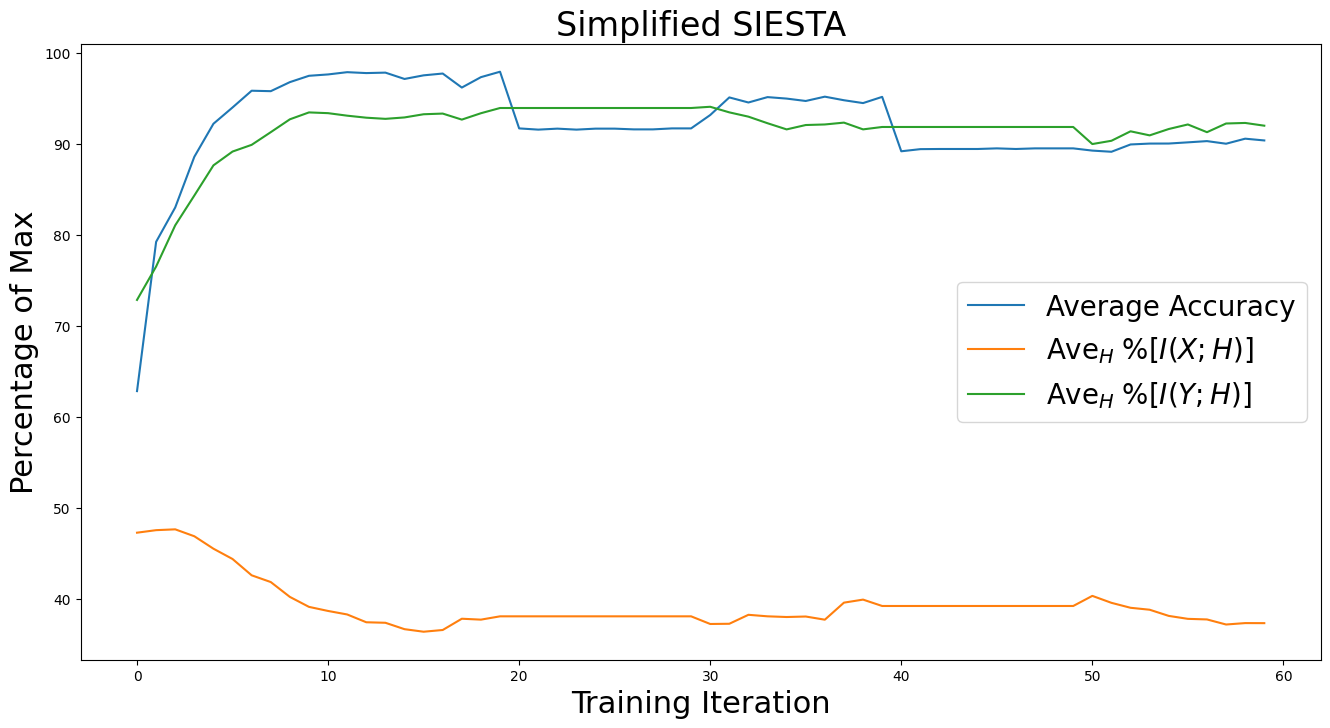

<Figure size 640x480 with 0 Axes>

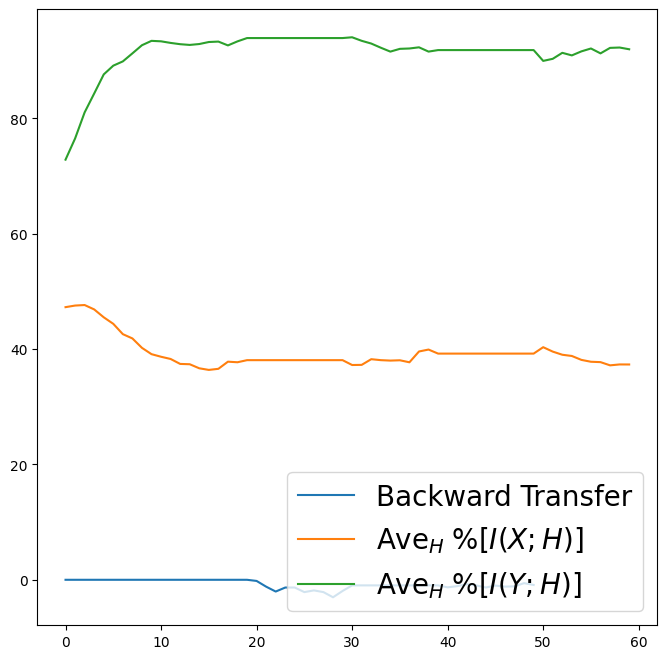

In [18]:
#@title Make Plots
plt.rc('axes', titlesize=24)
plt.rc('legend', fontsize=20)
plt.rc('axes', labelsize=22)

plt.figure()
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(ave_accuracy, label="Average Accuracy")
ax.plot(ave_MI_XH_perc, label="$\mathrm{Ave}_H \; \%[I(X;H)]$")
ax.plot(ave_MI_YH_perc, label="$\mathrm{Ave}_H \; \%[I(Y;H)]$")
plt.legend()
plt.title("Simplified SIESTA")
ax.set_xlabel('Training Iteration')
ax.set_ylabel("Percentage of Max")

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(backward_transfer, label="Backward Transfer")
ax.plot(ave_MI_XH_perc, label="$\mathrm{Ave}_H \; \%[I(X;H)]$")
ax.plot(ave_MI_YH_perc, label="$\mathrm{Ave}_H \; \%[I(Y;H)]$")
plt.legend()

In [21]:
#@title Animation Function
import matplotlib.lines as mlines
def animate_task_MI(XH_data, YH_data):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('MI_X,H')
    ax.set_xlim([0, XH_data.max() + 0.5])
    ax.set_ylim([0, YH_data.max() + 0.1])
    ax.set_ylabel('MI_Y,H')
    title = ax.set_title('Information Plane')
    # Construct epoch colour map (for dots)
    epochs = XH_data.size()[0]
    cmap_dots = plt.get_cmap('gnuplot', epochs+1)
    dot_colors = [cmap_dots(i) for i in np.arange(0, epochs+1)]

    # Construct layer colour map (for lines)
    layers = XH_data.size()[1]
    cmap_lines = plt.get_cmap('tab10', layers)
    line_colors = [cmap_lines(i) for i in np.arange(0, layers)]

    # initiate plot
    plots = {'layer': [], 'epoch': []}
    for layer in range(layers):
        x = XH_data[0,layer]
        y = YH_data[0,layer]
        plots["layer"].append(ax.plot(x, y, '-', color=line_colors[layer], label="Layer " + str(layer+1)))
        plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))

    def update(frame):
        # update axis data
        for layer in range(layers):
            x = XH_data[:frame,layer]
            y = YH_data[:frame,layer]
            plots["layer"][layer][0].set_xdata(x)
            plots["layer"][layer][0].set_ydata(y)
            data = np.stack([x,y]).T
            plots["epoch"][layer].set_offsets(data)
        # update lines
    ani = animation.FuncAnimation(fig=fig, func=update, frames=XH_data.size()[0], interval=300)
    return ani

def animate_all_MI(XH_data, YH_data, title_str):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('$\hat{I}(X,H)$')
    ax.set_xlim([0, XH_data.max() + 0.5])
    ax.set_ylim([0, YH_data.max() + 0.1])
    ax.set_ylabel('$\hat{I}(Y,H)$')
    title = ax.set_title(title_str)
    # Construct epoch colour map (for dots)
    num_tasks = len(tasks)
    epochs = XH_data.size()[1]
    cmap_dots = plt.get_cmap('gnuplot', num_tasks)
    dot_colors = []
    for task in range(num_tasks):
        dot_colors += [cmap_dots(task)] * epochs

    # Construct layer colour map (for lines)
    layers = XH_data.size()[2]
    cmap_lines = plt.get_cmap('tab10', layers)
    line_colors = [cmap_lines(i) for i in np.arange(0, layers)]

    # initiate plot
    plots = {'layer': [], 'epoch': []}
    for layer in range(layers):
        x = XH_data[0, 0, layer]
        y = YH_data[0, 0, layer]
        plots["layer"].append(ax.plot(x, y, '-', color=line_colors[layer], label="Layer " + str(layer+1)))
        plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))

    layer_plots_temp = []
    for layer in range(layers):
        layer_plots_temp.append(plots["layer"][layer][0])
    plots["layer"] = layer_plots_temp


    layer_legend = ax.legend(handles=plots["layer"], loc="center right")
    ax.add_artist(layer_legend)
    task_handles = []
    for task in range(num_tasks):
        legend_dot = mlines.Line2D([], [], color=cmap_dots(task), marker=".",
                                   markersize=15, label="Task " + str(task+1))
        task_handles.append(legend_dot)
    second_legend = ax.legend(handles=task_handles, loc="lower right")

    XH_data = torch.flatten(XH_data, start_dim=0, end_dim=1)
    YH_data = torch.flatten(YH_data, start_dim=0, end_dim=1)

    def update(frame):
        # update axis data
        for layer in range(layers):
            x = XH_data[:frame,layer]
            y = YH_data[:frame,layer]
            plots["layer"][layer].set_xdata(x)
            plots["layer"][layer].set_ydata(y)
            data = np.stack([x,y]).T
            plots["epoch"][layer].set_offsets(data)
            plots["epoch"][layer].set_color(dot_colors[:frame])
        # update lines
    fig.tight_layout()
    ani = animation.FuncAnimation(fig=fig, func=update, frames=XH_data.size()[0] + 10, interval=300)
    return ani

<ipython-input-21-cd8e330b0f11>:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))
<ipython-input-21-cd8e330b0f11>:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))
<ipython-input-21-cd8e330b0f11>:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mappi

<Figure size 640x480 with 0 Axes>

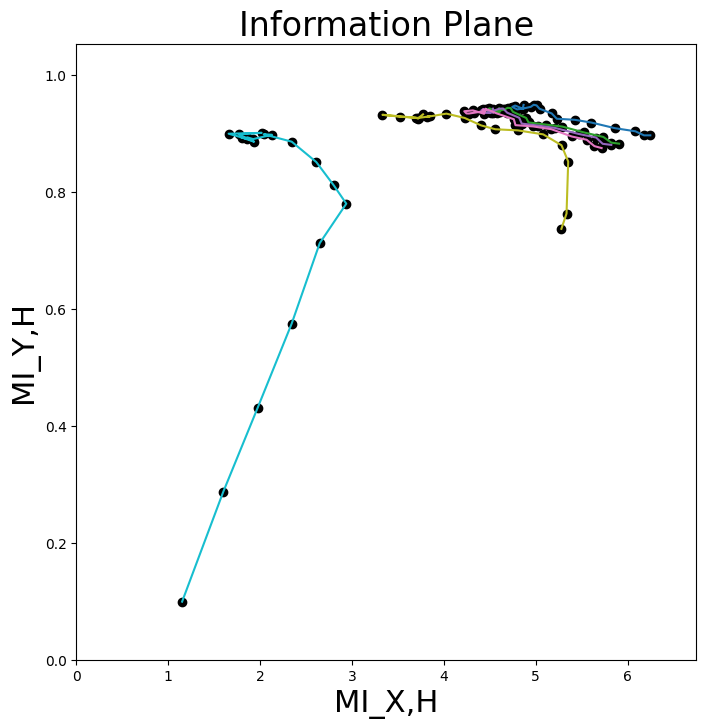

<Figure size 640x480 with 0 Axes>

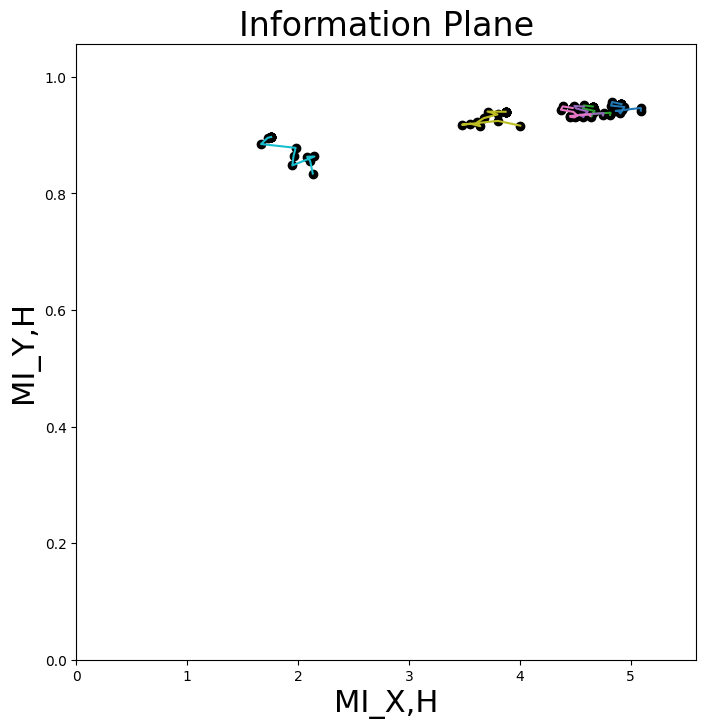

<Figure size 640x480 with 0 Axes>

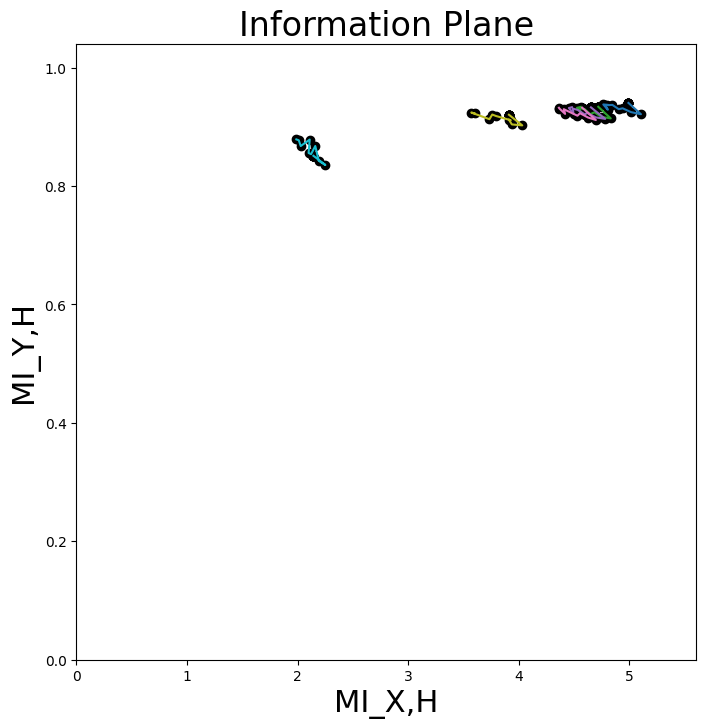

<Figure size 640x480 with 0 Axes>

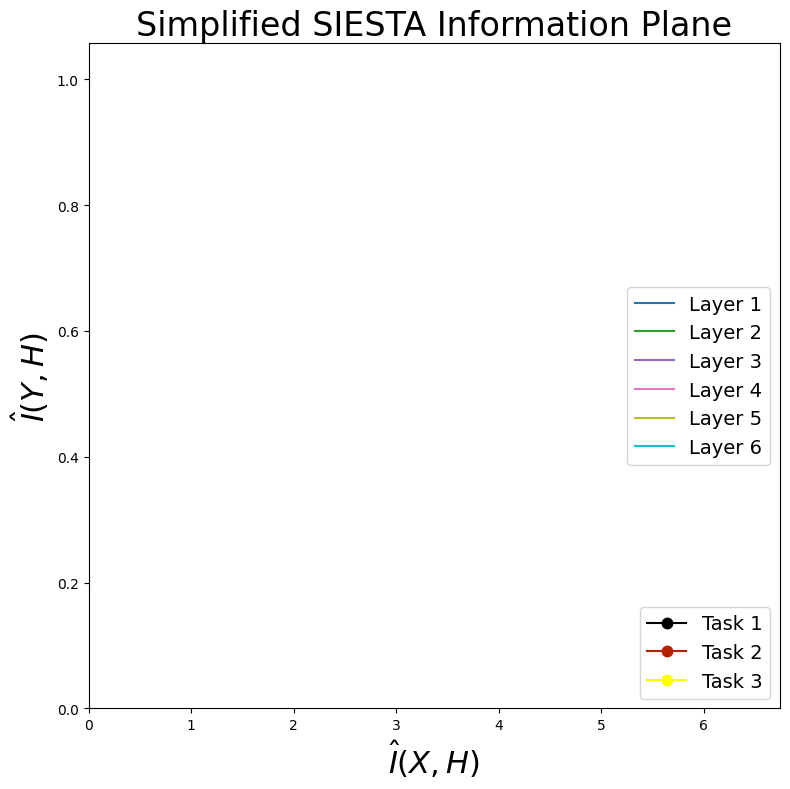

In [22]:
#@title Animation
plt.rc('legend', fontsize=14)
ani = animate_task_MI(MI_XH[0,:,:], MI_YH[0,:,:])
ani.save("rehearsal_task0.gif", writer="pillow")
ani = animate_task_MI(MI_XH[1,:,:], MI_YH[1,:,:])
ani.save("rehearsal_task1.gif", writer="pillow")
ani = animate_task_MI(MI_XH[2,:,:], MI_YH[2,:,:])
ani.save("rehearsal_task2.gif", writer="pillow")
ani = animate_all_MI(MI_XH, MI_YH, "Simplified SIESTA Information Plane")
ani.save("rehearsal_all_tasks.gif", writer="pillow")